This notebook is used to run Voigt profile fitting for a CGM absorption line toward a background qso, with a foreground host galaxy, the CGM absorber is associated with the foreground host galaxy, the redshift of the galaxy has been taken into account <br>
You should have read and understood the info_VoigtFit_analysis_steps.pdf and installed relevant packages before proceeding. <br>

<span style="color: red;">Note to yz, do no delete: saturation limit is only set for COS spec. If you are going to process STIS spec, need to update the sat limit in function voigtfit_mod_cgm.reproduce_voigt_model_fluxes</span> <br>

<span style="color: red;">Note to everyone: Before you start this notebook, you should activate the conda environment in terminal by running: <br>
conda activate env_voigt</span>

In [62]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import numpy as np 
import os
import linetools
from astropy.table import Table
import astropy
c_in_km_s = astropy.constants.c.to('km/s').value

import VoigtFit # the warning about line 1 being empty can be ignored 
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['font.family'] = 'stixgeneral'
import re
from pathlib import Path

from astropy.io import fits, ascii
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
c = 299792.46 # Speed of light in km/s

In [3]:
# analyze a chunk of the spec for each line around the galaxy's systemic velocity
# default is +/-400 km/s, but you can change this range to other numbers
plt_vmin = -400
plt_vmax = 400 

# Decide what QSO and galaxy targets to analyze 

<span style="color: red;">Input needed: change gal_name and qso_name</span>

In [4]:
# this is where you put QSO and galaxy names in

# qso_name = 'TON1129'
# gal_name = '85746'
# gal_vhel = 1457.0 # km/s

qso_name = 'FBQSJ095820.9+322402'
gal_name = '85746'
gal_vhel = 1457.0 # km/s

# qso_name = '2MASXJ12022678-0129155'
# gal_name = '140594'
# gal_vhel = 1461.8 # km/s

In [5]:
# heliocentric velocity of the galaxy, need to look this up from a catalog table
# gal_vhel = 1461.8 # km/s
gal_z = gal_vhel/c_in_km_s

In [6]:
# this is to indicate the binning that you may have done on the spectra to increase SNR
# can set this to None if there is no binning in the data 
data_nbin = 3

run the rest of the cells in this section, no need to change anything

In [7]:
# we'll save all the data in this directory
savedir = f'./data/{qso_name}/voigtfit'
linesdir = f'./data/{qso_name}/lines'
if os.path.isdir(savedir) == False: 
    print('voigtfit directory not found, make a new one: ', savedir)
    os.mkdir(savedir)
if os.path.isdir(linesdir) == False: 
    print('lines directory not found, make a new one: ', linesdir)
    os.mkdir(linesdir)

# all result willl be saved for this file naming structure
savename = f'{savedir}/{gal_name}_{qso_name}_voigtfit'
print('all files will be saved with this format: ', savename)

all files will be saved with this format:  ./data/FBQSJ095820.9+322402/voigtfit/85746_FBQSJ095820.9+322402_voigtfit


In [8]:
# HB added 3/19/25: generate line files

## Get list of LineTools absorption features from JSON file (created by pyigmguesses)
with open('./data/'+qso_name+'/'+qso_name+'.json') as data_file:  
    data = json.load(data_file)  
    lines = []
    components = []
    complims = []
    complim_ions = []
    for cmp in data["cmps"]:  
        cmp_dict=data["cmps"][str(cmp)]  
        cmp_data=''  
    # if cmp[-2:]=="HI": 
        if (c*(cmp_dict["zfit"]-gal_z)+cmp_dict["vlim"][0] > -500) & (c*(cmp_dict["zfit"]-gal_z)+cmp_dict["vlim"][1] < 500):
            cmp_data+=str(cmp)+'\t'  
            cmp_data+=str(cmp_dict["Nfit"])+'\t'  
            cmp_data+=str(c*(cmp_dict["zfit"]-gal_z)+cmp_dict["vlim"])+'\t'
            cmp_data+= str(cmp_dict["zfit"])+'\t'  
            cmp_data+=str(cmp_dict["bfit"]["value"])+'\t'  
            components.append(cmp_data) 
            complims.append(list([int(c*(cmp_dict["zfit"]-gal_z)+cmp_dict["vlim"][0]), int(c*(cmp_dict["zfit"]-gal_z)+cmp_dict["vlim"][1])]))
            complim_ions.append(str(cmp).split('_')[-1])
            print(cmp_data) 
            for line in data["cmps"][str(cmp)]["lines"]:
                lines.append(data["cmps"][str(cmp)]["lines"][line]["name"])
                continue
        # print(components)
complim_ions = np.array(complim_ions)
# complims = np.array(complims)


## Load spectrum and generate line files
from linetools.lists.linelist import LineList
ismlinelist = LineList('ISM')

spec_file = './data/'+qso_name+'/'+qso_name+'_ltnorm.fits'
raw_spec = fits.open(spec_file)
wave, flux, err, cont = raw_spec['WAVELENGTH'].data, raw_spec['FLUX'].data, raw_spec['ERROR'].data, raw_spec['CONTINUUM'].data
normflux, normerr = raw_spec['FLUX'].data/raw_spec['CONTINUUM'].data, raw_spec['ERROR'].data/raw_spec['CONTINUUM'].data

filedata = Table()
filedata['Wave'] = wave
filedata['NormFlux'] = normflux
filedata['NormErr'] = normerr
filedata['Flux'] = flux
filedata['Error'] = err
filedata['Continuum'] = cont

for line in lines:
    filename = './data/' + qso_name + '/lines/' + qso_name + '_' + line.replace(' ','') + '_refz' + str(gal_z) + '.txt'
    vel = c * (wave - ismlinelist['NI 1134b']['wrest'].value)/ismlinelist['NI 1134b']['wrest'].value # v = c * delta_lam/lam
    filedata['Vel'] = vel
    ascii.write(filedata['Wave','Vel','NormFlux','NormErr','Flux','Error','Continuum'], filename, 
                formats={'Wave':'.4f','Vel':'.2f','NormFlux':'.4f','NormErr':'.4f','Flux':'.4e','Error':'.4e','Continuum':'.4e'}, 
                format='commented_header', delimiter='\t', overwrite=True)

z0.00462_SiIV	13.73	[-129.57885768   21.63626384]	0.00468	57.5	
z0.00464_FeII	14.74	[-121.12032026    1.18602802]	0.00466	33.8	
z0.00464_OI	17.28	[-120.34614745    6.40770441]	0.00467	21.1	
z0.00465_SiII	14.98	[-107.67904289    5.73229825]	0.00469	35.4	
z0.00473_CII	16.33	[-129.08502442  111.08016857]	0.00483	51.3	
z0.00497_FeII	14.17	[ 2.17369454 57.76748922]	0.00496	13.7	
z0.00497_SiIV	13.63	[-27.17154842  75.12103378]	0.00494	41.3	
z0.00506_OI	15.53	[ -9.42293725 117.33091461]	0.00504	35.8	
z0.00507_SiII	14.51	[-14.2081439  128.11197046]	0.00505	52.3	
z0.00513_FeII	13.82	[53.8138189  96.06510286]	0.00511	10.0	
z0.00523_CII	18.08	[ 57.24821324 110.61825612]	0.00514	17.6	
z0.00549_CII	14.37	[148.73429686 210.9993469 ]	0.00546	24.0	
z0.00549_SiII	13.13	[140.61346253 225.11603043]	0.00547	21.8	


In [9]:
complims

[[-129, 21],
 [-121, 1],
 [-120, 6],
 [-107, 5],
 [-129, 111],
 [2, 57],
 [-27, 75],
 [-9, 117],
 [-14, 128],
 [53, 96],
 [57, 110],
 [148, 210],
 [140, 225]]

In [10]:
complim_ions

array(['SiIV', 'FeII', 'OI', 'SiII', 'CII', 'FeII', 'SiIV', 'OI', 'SiII',
       'FeII', 'CII', 'CII', 'SiII'], dtype='<U4')

In [11]:
lines

['SiIV 1393',
 'SiIV 1402',
 'FeII 1133',
 'FeII 1142',
 'FeII 1143',
 'FeII 1144',
 'FeII 1260',
 'OI 1302',
 'SiII 1190',
 'SiII 1193',
 'SiII 1260',
 'SiII 1304',
 'CII 1334',
 'FeII 1133',
 'FeII 1142',
 'FeII 1143',
 'FeII 1144',
 'FeII 1260',
 'SiIV 1393',
 'SiIV 1402',
 'OI 1302',
 'SiII 1190',
 'SiII 1193',
 'SiII 1260',
 'SiII 1304',
 'FeII 1143',
 'FeII 1144',
 'FeII 1260',
 'CII 1334',
 'CII 1334',
 'SiII 1190',
 'SiII 1193',
 'SiII 1260',
 'SiII 1304']

In [12]:
# find what QSO line data is available 
qso_dir = Path(f'./data/{qso_name}/lines/')
all_line_files = {}
matches = qso_dir.glob(f'{qso_name}*refz*.txt')
for ifile in matches: 
    line = ifile.stem.split('_')[1]
    if line == 'CII1335':  
        line = 'CII*1335' # this is what's used in linetools
    # because linetools require lines to have format of e.g., "SII 1250" instead of 'SII1250', 
    # let's modify previous list a bit
    new_line = re.sub(r'(\D)(\d)', r'\1 \2', line)
    all_line_files[new_line] = str(ifile)
    print(new_line, ifile)

SiIV 1402 data/FBQSJ095820.9+322402/lines/FBQSJ095820.9+322402_SiIV1402_refz0.0048600288670370756.txt
FeII 1144 data/FBQSJ095820.9+322402/lines/FBQSJ095820.9+322402_FeII1144_refz0.0048600288670370756.txt
FeII 1143 data/FBQSJ095820.9+322402/lines/FBQSJ095820.9+322402_FeII1143_refz0.0048600288670370756.txt
SiIV 1393 data/FBQSJ095820.9+322402/lines/FBQSJ095820.9+322402_SiIV1393_refz0.0048600288670370756.txt
FeII 1260 data/FBQSJ095820.9+322402/lines/FBQSJ095820.9+322402_FeII1260_refz0.0048600288670370756.txt
SiII 1190 data/FBQSJ095820.9+322402/lines/FBQSJ095820.9+322402_SiII1190_refz0.0048600288670370756.txt
FeII 1133 data/FBQSJ095820.9+322402/lines/FBQSJ095820.9+322402_FeII1133_refz0.0048600288670370756.txt
FeII 1142 data/FBQSJ095820.9+322402/lines/FBQSJ095820.9+322402_FeII1142_refz0.0048600288670370756.txt
SiII 1193 data/FBQSJ095820.9+322402/lines/FBQSJ095820.9+322402_SiII1193_refz0.0048600288670370756.txt
OI 1302 data/FBQSJ095820.9+322402/lines/FBQSJ095820.9+322402_OI1302_refz0.00486002

In [13]:
## read atomic data from linetools for these lines
# note that not all lines will be used for Voigt profile fitting later 
line_list = all_line_files.keys()
from linetools.lists.linelist import LineList
llist_ism = LineList('ISM')._data.to_pandas()
llist_ism['species'] = llist_ism['name'].str.split().str[0]
all_line_info = llist_ism.query('(name in @line_list)').sort_values("wrest")
#all_line_info = Table.from_pandas(all_line_info) # only if you want to change it to an astropy table from pandas
#all_line_info.remove_columns(['A', 'el', 'nj', 'nk', 'group', 'Ek', 'mol', 'Ej', 'Am', 'Ex', 'Jj', 'Jk', 'gk', 'gj', 'gamma', 'Id'])
all_line_info

,A,el,nj,nk,group,name,Ek,f,wrest,Ref,...,ion,Ex,Jj,Jk,Z,gk,gj,gamma,Id,species
229,3.060000e+07,0,0,0,1,FeII 1133,88209.450,0.00550,1133.6654,Morton2003,...,2,0.0,0.0,0.0,26,8,10,0.000000e+00,229,FeII
241,2.560000e+07,0,0,0,1,FeII 1142,87537.652,0.00401,1142.3656,Morton2003,...,2,0.0,0.0,0.0,26,8,10,0.000000e+00,241,FeII
242,9.810000e+07,0,0,0,1,FeII 1143,87471.765,0.01920,1143.2260,Morton2003,...,2,0.0,0.0,0.0,26,0,10,0.000000e+00,242,FeII
243,3.520000e+08,0,0,0,1,FeII 1144,87340.983,0.08300,1144.9379,Morton2003,...,2,0.0,0.0,0.0,26,2,10,0.000000e+00,243,FeII
253,6.860000e+08,0,0,0,1,SiII 1190,84004.260,0.29200,1190.4158,Morton2003,...,2,0.0,0.0,0.0,14,4,2,4.080000e+09,253,SiII
257,2.730000e+09,0,0,0,1,SiII 1193,83801.950,0.58200,1193.2897,Morton2003,...,2,0.0,0.0,0.0,14,2,2,4.070000e+09,257,SiII
277,2.470000e+09,0,0,0,1,SiII 1260,79338.500,1.18000,1260.4221,Morton2003,...,2,0.0,0.0,0.0,14,4,2,2.950000e+09,277,SiII
278,1.260000e+08,0,0,0,1,FeII 1260,79331.500,0.02400,1260.5330,Morton2003,...,2,0.0,0.0,0.0,26,8,10,0.000000e+00,278,FeII
305,3.150000e+08,0,0,0,1,OI 1302,76794.978,0.04800,1302.1685,Morton2003,...,1,0.0,0.0,0.0,8,3,5,5.650000e+08,305,OI
306,3.390000e+08,0,0,0,1,SiII 1304,76665.350,0.08630,1304.3702,Morton2003,...,2,0.0,0.0,0.0,14,2,2,1.010000e+09,306,SiII


./data/FBQSJ095820.9+322402/voigtfit/85746_FBQSJ095820.9+322402_alllines_nofit.pdf
Figure saved to:  ./data/FBQSJ095820.9+322402/voigtfit/85746_FBQSJ095820.9+322402_alllines_nofit.pdf


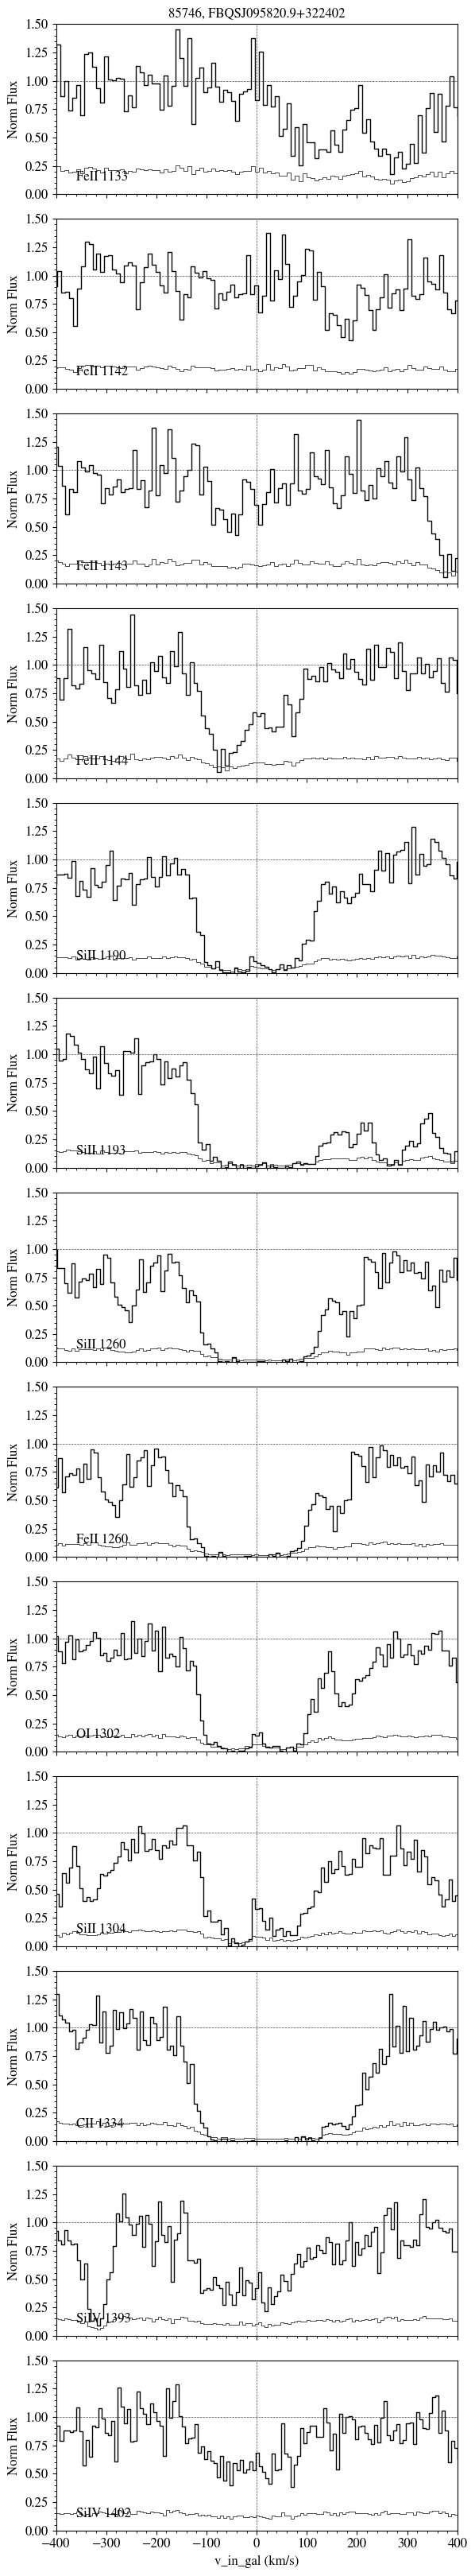

In [14]:
# we'll make a quick plot that shows all the available line data
figname = f'{savedir}/{gal_name}_{qso_name}_alllines_nofit.pdf'
print(figname)

from voigtfit_mod_cgm import plot_lines
plot_lines(gal_vhel, gal_name, qso_name, all_line_info, all_line_files, figname=figname, vmin=plt_vmin, vmax=plt_vmax)

In [15]:
all_line_files.keys()

dict_keys(['SiIV 1402', 'FeII 1144', 'FeII 1143', 'SiIV 1393', 'FeII 1260', 'SiII 1190', 'FeII 1133', 'FeII 1142', 'SiII 1193', 'OI 1302', 'CII 1334', 'SiII 1260', 'SiII 1304'])

# Decide which lines to fit for 

<span style="color: red;">Input needed: change lines_to_fit</span> <br>
Note: For CII* 1335, linetools call it "CII* 1335", while VoigtFit use "CIIa_1335.71" instead. So if you are using CII* 1335 line, make sure you are using the right ion and line name input for VoigtFit. 

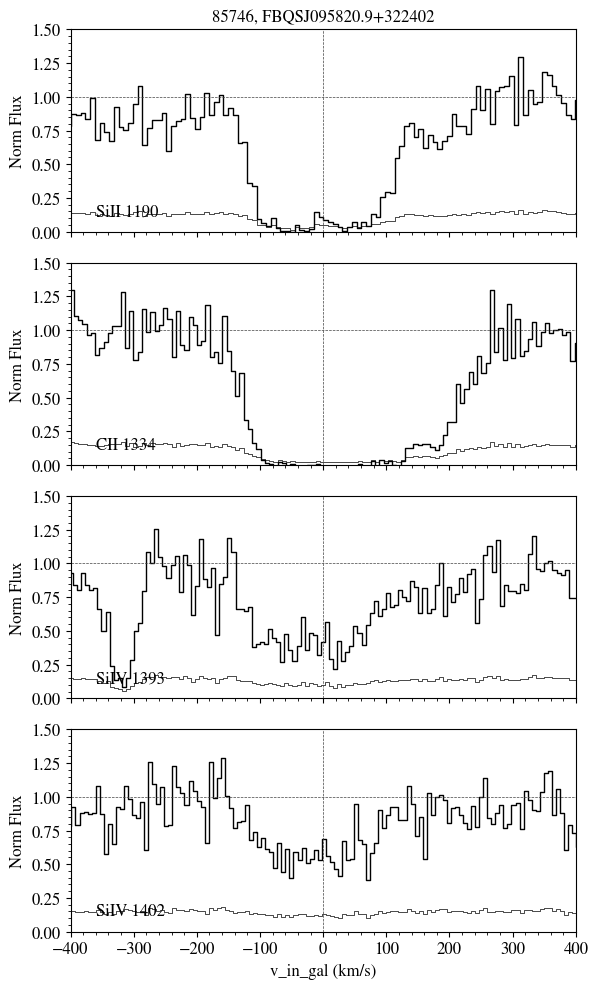

In [71]:
# here we decide to fit a few lines based on the plot above
# lines_to_fit = all_line_files.keys()
# lines_to_fit = ['SiIV 1402', 'FeII 1144', 'FeII 1143', 'SiIV 1393', 'FeII 1260', 'SiII 1190', 'FeII 1133', 'FeII 1142', 'SiII 1193', 'OI 1302', 'CII 1334', 'SiII 1260', 'SiII 1304']
lines_to_fit = ['SiIV 1402', 'SiIV 1393', 'CII 1334','SiII 1190']
# lines_to_fit = ['HI 1215']#,'SiIV 1393','SiIV 1402']#, 'HI 1025']#, 'HI 972', 'HI 949', 'HI 937']
# lines_to_fit = ['SiIV 1393', 'SiIV 1402']
# lines_to_fit = ['SiII 1193', 'SiII 1260', 'SiIII 1206']
# lines_to_fit = ['FeII 1143', 'FeII 1144', 'PII 1152', 'SiII 1193', 'SiII 1260', 'SiIII 1206', 'NV 1238', 'NV 1242', 
#                    'CII 1334', 'SiIV 1393', 'SiIV 1402']

# we take a sub list of line info that we'd fit for 
lines_to_fit_info = all_line_info.query('(name in @lines_to_fit)')
plot_lines(gal_vhel, gal_name, qso_name, lines_to_fit_info, all_line_files, vmin=plt_vmin, vmax=plt_vmax)

Have an initial guesses on the voigt profile parameters based on AOD<br>
<span style="color: red;">Input needed: change vcomps based on figure above</span>

In [72]:
# Added by HVB: list the component limits you fit in pyigmguesses
[print(c) for c in components];

z0.00462_SiIV	13.73	[-129.57885768   21.63626384]	0.00468	57.5	
z0.00464_FeII	14.74	[-121.12032026    1.18602802]	0.00466	33.8	
z0.00464_OI	17.28	[-120.34614745    6.40770441]	0.00467	21.1	
z0.00465_SiII	14.98	[-107.67904289    5.73229825]	0.00469	35.4	
z0.00473_CII	16.33	[-129.08502442  111.08016857]	0.00483	51.3	
z0.00497_FeII	14.17	[ 2.17369454 57.76748922]	0.00496	13.7	
z0.00497_SiIV	13.63	[-27.17154842  75.12103378]	0.00494	41.3	
z0.00506_OI	15.53	[ -9.42293725 117.33091461]	0.00504	35.8	
z0.00507_SiII	14.51	[-14.2081439  128.11197046]	0.00505	52.3	
z0.00513_FeII	13.82	[53.8138189  96.06510286]	0.00511	10.0	
z0.00523_CII	18.08	[ 57.24821324 110.61825612]	0.00514	17.6	
z0.00549_CII	14.37	[148.73429686 210.9993469 ]	0.00546	24.0	
z0.00549_SiII	13.13	[140.61346253 225.11603043]	0.00547	21.8	


In [73]:
complim_ions

array(['SiIV', 'FeII', 'OI', 'SiII', 'CII', 'FeII', 'SiIV', 'OI', 'SiII',
       'FeII', 'CII', 'CII', 'SiII'], dtype='<U4')

In [74]:
[comp for comp, ion in zip(complims, complim_ions) if ion == 'SiIV']

[[-129, 21], [-27, 75]]

In [75]:
[comp for comp, ion in zip(complims, complim_ions) if ion == 'FeII']

[[-121, 1], [2, 57], [53, 96]]

In [76]:
# based on the spectral above, let's do an initial guess on components based on aod results
# for each ion, you just need to specify a set of velocity ranges, 
# for example, no need to specify velocity ranges for SiIV 1393 and SiIV 1402 separately
vcomps = {#'HI': [comp for comp, ion in zip(complims, complim_ions) if ion == 'HI'],
          # 'FeII': [comp for comp, ion in zip(complims, complim_ions) if ion == 'FeII'], 
          # 'OI': [comp for comp, ion in zip(complims, complim_ions) if ion == 'OI'], 
          # # 'PII': [[-150, 20]], 
          # # 'SiIII': [[-180, -100], [-100, 40]], 
          'SiII': [comp for comp, ion in zip(complims, complim_ions) if ion == 'SiII'], 
          # # 'NV': [[-180, 20]], 
          'CII': [comp for comp, ion in zip(complims, complim_ions) if ion == 'CII'], 
          'SiIV': [comp for comp, ion in zip(complims, complim_ions) if ion == 'SiIV']
}

print(vcomps)

# this is a string that combines all ions to fit together, will be used to save data
ion_list = '-'.join(np.sort(list(vcomps.keys())))

from voigtfit_mod_cgm import estimate_init_guess_params
param_guess = estimate_init_guess_params(vcomps, lines_to_fit_info, all_line_files, gal_vhel)
param_guess

{'SiII': [[-107, 5], [-14, 128], [140, 225]], 'CII': [[-129, 111], [57, 110], [148, 210]], 'SiIV': [[-129, 21], [-27, 75]]}


ion,vmin,vmax,z,vhel,v_in_gal,b,logN
str4,int64,int64,float64,float64,float64,float64,float64
SiII,-107,5,0.004696,1407.8,-49.2,42.0,14.57
SiII,-14,128,0.005013,1503.0,46.0,47.4,14.55
SiII,140,225,0.005462,1637.4,180.4,30.7,13.47
CII,-129,111,0.004857,1456.1,-0.9,88.1,15.25
CII,57,110,0.005132,1538.5,81.5,21.3,14.62
CII,148,210,0.005448,1633.4,176.4,22.6,14.36
SiIV,-129,21,0.004701,1409.3,-47.7,60.0,13.85
SiIV,-27,75,0.004929,1477.7,20.7,38.9,13.7


<span style="color: red;">Input needed: change vcomps_exclude based on figure above</span>

In [77]:
# there may be contaminating components in some lines, in which case we'll exclude that chunk of data from the fit 
# here you need to specify which line may have contamination 
# each line has a nested list, you can put in multiple velocity ranges in a line if necessary
vcomps_exclude = { 'SiIV 1393': [[-400, -250]], 
                  # 'SiIV 1402': [[30, 170]], 
                  #'SiII 1260': [[60, 180]], 
                  #'SiIII 1206': [[10, 150]], 
                  #'SiII 1193': [[70, 130]], 
                  #'CII 1334': [[50, 120]], 
                  #'SiII 1260': [[50, 180]]
                 }

In [78]:
# tie_ions = None

# this is a nested list, each list shows the ion that you'd like to tie together 
# if you want to tie multiple ions together, you can do something like: tie_ions = [['SiII', 'SiIII', 'SiIV']]
# if you want to tie two sets of ions separately, such as SiII, SiIII, SiIV together, and then PII and FeII together, 
# you can do: tie_ions = [['SiII', 'SiIII', 'SiIV'], ['PII', 'FeII']]

tie_ions_list = [['SiII', 'SiIII']]

# Note: the VoigtFit package allows to tie specific velocity components together, or tie v or logN or b
# but here we will only tie velocity togethers for all velocity components
# with the assumption that tied ions are co-spatial, thus share the same kinematics

# Initialize fitting with VoigtFit <br>
add spectral data, lines, and components, and velocity masks if needed <br>
<span style="color: red;">Input needed: change iterative_fit to true or false</span>

In [79]:
# Use False if this is the first time you are doing the fit
# Use True if if you want to use the previous round of fitting result do an interative fit
iterative_fit = False

if iterative_fit == False: 
    input_tb = param_guess.copy()  # first fit, parameters come from initial guess
    print('You are doing a first fit based on AOD initial guesses')
else: 
    input_tb = param_bestfit.copy() # iterative fit, parameters from the previous round of fitting
    print('You are doing an iterative fit based on the previous round of best fit parameters')

You are doing a first fit based on AOD initial guesses


Run the rest of the cells, no need to change anything

In [80]:
### initialize fitting, add data, and add lines
dataset = VoigtFit.DataSet(gal_z) # initial dataset by putting in the galaxy redshift 

## add velocity components based on initial guesses 
from voigtfit_mod_cgm import voigtfit_dataset_add_component
# note: if two components have centroid velocity more than close_comp_maxv apart
# they are not considered the same component, and won't be tied together. 
dataset = voigtfit_dataset_add_component(dataset, input_tb, tie_ions_list=tie_ions_list, close_comp_maxv=30)

lsf/cos_lsf_g130m_average_lp1-4_bin3_yz.txt
lsf/cos_lsf_g130m_average_lp1-4_bin3_yz.txt
lsf/cos_lsf_g130m_average_lp1-4_bin3_yz.txt
lsf/cos_lsf_g130m_average_lp1-4_bin3_yz.txt


 [WARNING]  -  Check-lines is activated
 The following lines of included ions are also covered by the data:

     SiII_1193 :  f = 5.94e-01
     SiII_1260 :  f = 1.45e+00
     SiII_1304 :  f = 1.06e-01
     SiII_1193 :  f = 5.94e-01
     SiII_1260 :  f = 1.45e+00
     SiII_1304 :  f = 1.06e-01
     SiII_1193 :  f = 5.94e-01
     SiII_1260 :  f = 1.45e+00
     SiII_1304 :  f = 1.06e-01
     SiII_1193 :  f = 5.94e-01
     SiII_1260 :  f = 1.45e+00
     SiII_1304 :  f = 1.06e-01



  Fit is running... Please be patient.



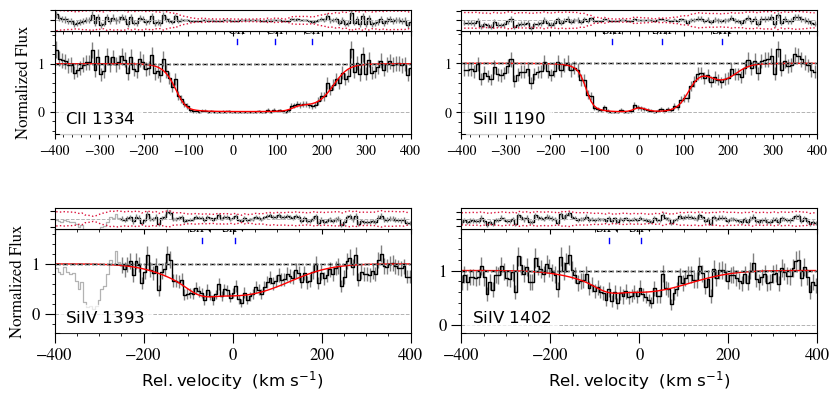

In [81]:
### add line and data
for line_name in lines_to_fit: 
    ## determine what lsf to use, note that this is binned data 
    from voigtfit_mod_cgm import determine_cos_lsf_file
    cos_lsf_file = determine_cos_lsf_file(line_name, data_nbin=data_nbin)
    print(cos_lsf_file)
    
    # read the corresponding data and estimate aod within the velocity range 
    line_datafile = all_line_files[line_name]
    line_spec = Table.read(line_datafile, format='ascii')

    # add data and line 
    dataset.add_data(line_spec['Wave'], line_spec['NormFlux'], cos_lsf_file, 
                     err=line_spec['NormErr'], normalized=True)
    # note that Linetools line format is "SiIV 1393", but 
    # VoigtFit package line format is "SiIV_1393"
    dataset.add_line(line_name.replace(' ', '_')) 

### add masks to exlude some velocity components in certain lines 
if len(vcomps_exclude) != 0:
    for key in vcomps_exclude: 
        for v_exc in vcomps_exclude[key]: 
            dataset.mask_range(key.replace(' ', '_'), v_exc[0], v_exc[1])

### also for all lines, we automatically mask anything beyond +/-400 km/s
for line_name in lines_to_fit: 
    dataset.mask_range(line_name.replace(' ', '_'), -100000, plt_vmin)
    dataset.mask_range(line_name.replace(' ', '_'), plt_vmax, +100000)

# Crucial step, prepare dataset, Run the fit:
dataset.prepare_dataset(verbose=False)
popt, chi2 = dataset.fit(verbose=False)
dataset.plot_fit(label_all_ions=True) # legend=False, 

In [82]:
dataset.plot_fit?

Signature:
dataset.plot_fit(
    rebin=1,
    fontsize=12,
    xmin=None,
    xmax=None,
    max_rows=4,
    ymin=None,
    ymax=None,
    filename=None,
    subsample_profile=10,
    npad=50,
    loc='left',
    highlight_props=None,
    residuals=True,
    norm_resid=False,
    default_props={},
    element_props={},
    legend=True,
    label_all_ions=False,
    xunit='vel',
    line_props=None,
    hl_line_props=None,
    individual=False,
)
Docstring:
Plot *all* the absorption lines and the best-fit profiles.
For details, see :func:`VoigtFit.output.plot_all_lines`.
File:      ~/anaconda3/envs/voigtfit/lib/python3.12/site-packages/VoigtFit/container/dataset.py
Type:      method

In [70]:
ion_list

'CII-FeII-HI-OI-SiII-SiIV'

In [67]:
display(input_tb)
#### save the best result into a txt file 
from voigtfit_mod_cgm import parse_output_to_astropy_table
tbname = f'{savename}_{ion_list}_vfit-param.txt'
param_bestfit = parse_output_to_astropy_table(dataset.best_fit, popt, gal_vhel, tbname=tbname)
display(param_bestfit)

ion,vmin,vmax,z,vhel,v_in_gal,b,logN
str4,int64,int64,float64,float64,float64,float64,float64
CII,-129,111,0.004857,1456.1,-0.9,88.1,15.25
CII,57,110,0.005132,1538.5,81.5,21.3,14.62
CII,148,210,0.005448,1633.4,176.4,22.6,14.36
SiIV,-129,21,0.004701,1409.3,-47.7,60.0,13.85
SiIV,-27,75,0.004929,1477.7,20.7,38.9,13.7


Saving best fit parameters to:  ./data/FBQSJ095820.9+322402/voigtfit/85746_FBQSJ095820.9+322402_voigtfit_CII-FeII-HI-OI-SiII-SiIV_vfit-param.txt


ion,z,z_e,vhel,vhel_e,v_in_gal,v_in_gal_e,b,b_e,flag,logN,logN_e
str5,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64
CII,0.00489,2.2e-05,1465.99,6.6,9.0,6.6,58.51,17.61,N/A,16.56,0.89
CII,0.005191,0.000617,1556.22,184.97,99.2,184.97,121.32,69.86,N/A,14.76,1.18
CII,0.005469,2e-05,1639.56,6.0,182.6,6.0,20.46,11.68,N/A,14.16,0.3
SiIV,0.004627,3.4e-05,1387.14,10.19,-69.9,10.19,25.74,18.56,N/A,13.08,0.23
SiIV,0.004879,3.2e-05,1462.69,9.59,5.7,9.59,139.67,7.9,N/A,14.09,0.04


In [68]:
dataset.best_fit

name,value,standard error,relative error,initial value,min,max,vary
sid_8fc552_dvel,0.00000000,0.00000000,,0.0,-inf,inf,False
sid_8fc552_dlam,0.00000000,0.00000000,,0.0,-5.00000000,5.00000000,False
z0_CII,0.00489043,2.1639e-05,(0.44%),0.004857,-inf,inf,True
b0_CII,58.5058394,17.6117648,(30.10%),88.1,0.00000000,inf,True
logN0_CII,16.5582184,0.88959634,(5.37%),15.25,-inf,inf,True
z1_CII,0.00519142,6.1696e-04,(11.88%),0.005132,-inf,inf,True
b1_CII,121.317104,69.8642155,(57.59%),21.3,0.00000000,inf,True
logN1_CII,14.7578182,1.18249409,(8.01%),14.62,-inf,inf,True
z2_CII,0.00546935,2.0434e-05,(0.37%),0.005448,-inf,inf,True
b2_CII,20.4568098,11.6831710,(57.11%),22.6,0.00000000,inf,True


Save voigt fit fluxes to:  ./data/FBQSJ095820.9+322402/voigtfit/85746_FBQSJ095820.9+322402_voigtfit_CII1334_vfit-flux.txt
Save voigt fit fluxes to:  ./data/FBQSJ095820.9+322402/voigtfit/85746_FBQSJ095820.9+322402_voigtfit_SiIV1393_vfit-flux.txt
Save voigt fit fluxes to:  ./data/FBQSJ095820.9+322402/voigtfit/85746_FBQSJ095820.9+322402_voigtfit_SiIV1402_vfit-flux.txt
Figure saved to:  ./data/FBQSJ095820.9+322402/voigtfit/85746_FBQSJ095820.9+322402_voigtfit_CII-FeII-HI-OI-SiII-SiIV_vfit.pdf


ion,z,z_e,vhel,vhel_e,v_in_gal,v_in_gal_e,b,b_e,flag,logN,logN_e
str5,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64
CII,0.00489,2.2e-05,1465.99,6.6,9.0,6.6,58.51,17.61,>,16.56,0.89
CII,0.005191,0.000617,1556.22,184.97,99.2,184.97,121.32,69.86,=,14.76,1.18
CII,0.005469,2e-05,1639.56,6.0,182.6,6.0,20.46,11.68,=,14.16,0.3
SiIV,0.004627,3.4e-05,1387.14,10.19,-69.9,10.19,25.74,18.56,=,13.08,0.23
SiIV,0.004879,3.2e-05,1462.69,9.59,5.7,9.59,139.67,7.9,=,14.09,0.04


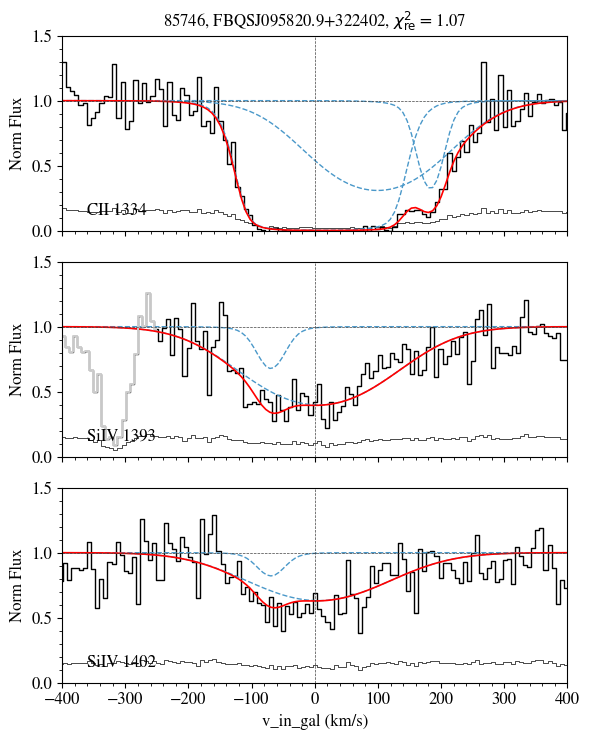

In [69]:
#### save model fluxes 
from voigtfit_mod_cgm import reproduce_voigt_model_fluxes
model_filenames = reproduce_voigt_model_fluxes(lines_to_fit_info, param_bestfit, all_line_files, savename, 
                                               gal_vhel, plt_vmin=plt_vmin, plt_vmax=plt_vmax, data_nbin=data_nbin,
                                               tbname=tbname)

#### plot the result
from voigtfit_mod_cgm import plot_lines
figname = f'{savename}_{ion_list}_vfit.pdf'
plot_lines(gal_vhel, gal_name, qso_name, lines_to_fit_info, all_line_files, figname=figname,
           model_filenames=model_filenames, vcomps_exclude=vcomps_exclude, vmin=plt_vmin, vmax=plt_vmax, 
           reduced_chi2=param_bestfit.meta['comments'][1].split('=')[1])

param_bestfit